In [8]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [2]:
DATA_PATH="Data Varsity/"

In [3]:
loader = DirectoryLoader(DATA_PATH,
                             glob='*.pdf',
                             loader_cls=PyPDFLoader)

In [4]:
docs=loader.load()

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [6]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [ ]:
docs

In [55]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [56]:
counts = [num_tokens_from_string(t) for t in texts]

<function matplotlib.pyplot.show(close=None, block=None)>

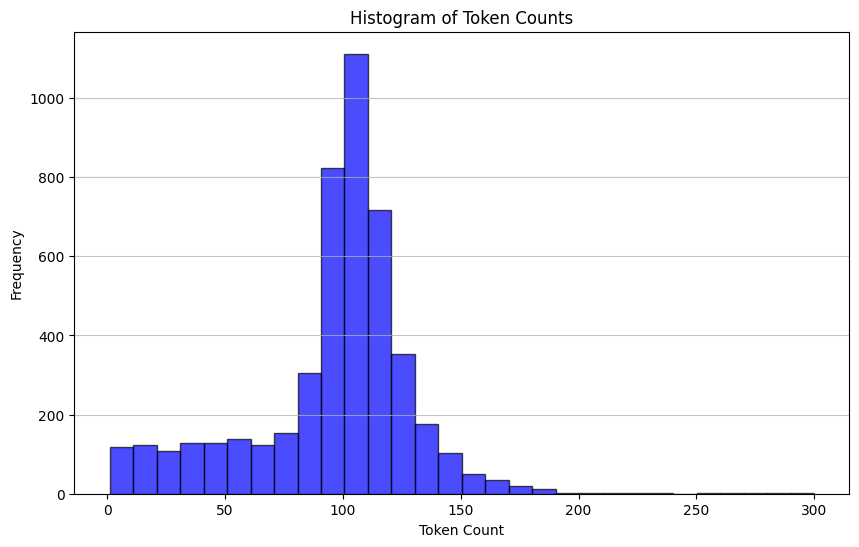

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [58]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 467868


In [1]:
from RAPTOR import recursive_embed_cluster_summarize

In [23]:
leaf_texts = texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 83 clusters--
--Generated 17 clusters--
--Generated 3 clusters--


In [26]:
type(results)

dict

In [27]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

In [ ]:
all_texts

In [4]:
from pymilvus import (
    Collection,
    CollectionSchema,
    DataType,
    FieldSchema,
    WeightedRanker,
    connections,
)

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_milvus.retrievers import MilvusCollectionHybridSearchRetriever
from langchain_milvus.utils.sparse import BM25SparseEmbedding
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [6]:
CONNECTION_URI = "http://localhost:19530"

In [10]:
dense_embedding_func=HuggingFaceBgeEmbeddings(
    model_name="sentence-transformers/all-MiniLM-l6-v2",      
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True}

)

c:\Users\adith\OneDrive\Desktop\Steps AI\myenv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [12]:
sparse_embedding_func = BM25SparseEmbedding(corpus=all_texts)
#sparse_embedding_func.embed_query(texts[1])

In [36]:
import pickle
with open('sparse_embedding_func.pkl', 'wb') as f:
    pickle.dump(sparse_embedding_func, f)

In [13]:
connections.connect(uri=CONNECTION_URI)

In [14]:
pk_field = "doc_id"
dense_field = "dense_vector"
sparse_field = "sparse_vector"
text_field = "text"
fields = [
    FieldSchema(
        name=pk_field,
        dtype=DataType.VARCHAR,
        is_primary=True,
        auto_id=True,
        max_length=100,
    ),
    FieldSchema(name=dense_field, dtype=DataType.FLOAT_VECTOR, dim=dense_dim),
    FieldSchema(name=sparse_field, dtype=DataType.SPARSE_FLOAT_VECTOR),
    FieldSchema(name=text_field, dtype=DataType.VARCHAR, max_length=65_535),
]

In [15]:
schema = CollectionSchema(fields=fields, enable_dynamic_field=False)
collection = Collection(
    name="StockMarket", schema=schema, consistency_level="Strong"
)

In [16]:
dense_index = {"index_type": "FLAT", "metric_type": "IP"}
collection.create_index("dense_vector", dense_index)
sparse_index = {"index_type": "SPARSE_INVERTED_INDEX", "metric_type": "IP"}
collection.create_index("sparse_vector", sparse_index)
collection.flush()

In [17]:
entities = []
for text in all_texts:
    entity = {
        dense_field: dense_embedding_func.embed_documents([text])[0],
        sparse_field: sparse_embedding_func.embed_documents([text])[0],
        text_field: text,
    }
    entities.append(entity)
collection.insert(entities)
collection.load()